# AVISO : Colocalisation d'observations avec le datacube

Dans les parties précédentes nous avons construit et testé le datacube. Ici, nous allons réaliser des tests de colocalisation entre le datacube et les points d'observations. Pour chaque point d'observations, nous allons extraire un petit cube et enregistrer les résultats dans des fichiers NetCDF.

In [1]:
import os
import dask
import intake
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import dask_jobqueue
import dask.distributed

from pathlib import Path

## Cluster Dask

In [2]:
# Création du cluster Dask
cluster = dask_jobqueue.PBSCluster(queue='mpi', 
                                   cores=28,
                                   memory="115GB",
                                   walltime="04:00:00",
                                   interface='ib0',
                                   local_directory='/tmp',
                                   log_directory='/home1/scratch/gcaer/dask-logs',
                                   #processes=,
                                  )
cluster.scale(jobs=2)

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52791 instead
  warnings.warn(


In [3]:
client = dask.distributed.Client(cluster, timeout=600)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.134:52791/status,
Dashboard: http://10.148.1.134:52791/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.134:33955,Workers: 0
Dashboard: http://10.148.1.134:52791/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [ ]:
port = client.scheduler_info()["services"]["dashboard"]
ssh_command = f'ssh -N -L {port}:{os.environ["HOSTNAME"]}:{port} {os.environ["USER"]}@datarmor.ifremer.fr'

print(f"{ssh_command}")
print(f"open browser at address of the type: http://localhost:{port}")

## Ouverture du datacube

In [8]:
# Chemin vers le datacube
wrk = Path('/home/datawork-data-terra/odatis/data')
name = 'aviso'
version = 'datacube-year'
output = wrk / name / version

In [9]:
%%time
# Ouverture du datacube
start, end = 2018, 2020
chunks = {"time": 1, "latitude": -1, "longitude": -1}
vars = ["crs","lat_bnds","lon_bnds","ugosa","err_ugosa","vgosa","err_vgosa","ugos","vgos","flag_ice","tpa_correction","nv",]
cat = intake.open_catalog(output / "reference.yaml")
datacubes = [cat[str(year)](chunks=chunks).to_dask().drop_vars(vars) for year in range(start, end+1)]
datacube = xr.concat(datacubes, dim="time")

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


CPU times: user 19.1 s, sys: 2.1 s, total: 21.2 s
Wall time: 30.6 s


/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


## Ouverture des matchups

In [10]:
# Ouverture des matchups
label = 'gps_Jason-3_2019'
#label = 'argos_Jason-3_2019'
zarr_dir = Path("/home/datawork-lops-osi/aponte/margot/historical_coloc")
ds_raw = xr.open_zarr(zarr_dir / f'{label}.zarr')

## Pré-traitements des matchups

In [11]:
dlon, dlat = 5, 5 # +/- Nombre de degrée à extraire autour du point d'observation
dt = (-2, 3)# +/- Nombre de jour à extraire autour du point d'observation (+/- 2 jour)
dl = 0.25 # Pas entre chaque coordonnée longitude/latitude du datacube
N_lon, N_lat = int(2*dlon/dl), int(2*dlat/dl) # Nombre de points en longitude/latitude (40,40)

In [12]:
def preprocessing(ds, **kwargs):
    """Pré-traitement du dataset avec les points d'observation pour préparer l'étape de colocalisation."""
    # Sélection des matchups avec une distance inférieur à 200km ? 
    ds = ds.where(ds_raw.alti___distance.compute()<2e5, drop=True)

    # Sélection uniquement des variables d'intérets
    ds = ds[['time', 'lat', 'lon']]

    # Pour chaque observation, définition de l'extension à extraire
    ds['lon_min'] = (ds.lon - kwargs['dlon'])
    ds['lon_max'] = (ds.lon + kwargs['dlon'])
    ds['lat_min'] = (ds.lat - kwargs['dlat'])
    ds['lat_max'] = (ds.lat + kwargs['dlat'])

    def set_spatial_array(_mins, _maxs, **kwargs):
        """Pour chaque observation, on génère un array de N valeurs entre min et max"""
        return np.array([np.linspace(_min, _max, int(kwargs['N'])) for _min, _max in zip(_mins, _maxs)])

    def set_time_array(time_values, **kwargs):
        """Pour chaque observation, on génère un array de valeurs, allant de time_value - dt[0] à time_value + dt[1]"""
        return np.array([[ (time_value + np.timedelta64(_dt, 'D')).astype(np.int64) for _dt in range(*kwargs['dt'])] for time_value in time_values])

    # Pour chaque observation génère un array de N_lon coordonnées à extraire entre lon_min et lon_max
    ds['array_lon'] = xr.apply_ufunc(
        set_spatial_array, 
        ds['lon_min'], 
        ds['lon_max'],
        input_core_dims=[[], []],
        output_core_dims=[['x']],
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={'x': kwargs['N_lon']}),
        dask='parallelized',
        kwargs={'N': kwargs['N_lon']} 
    )

    # Pour chaque observation génère un array de N_lat coordonnées à extraire entre lat_min et lat_max
    ds['array_lat'] = xr.apply_ufunc(
        set_spatial_array, 
        ds['lat_min'], 
        ds['lat_max'],
        input_core_dims=[[], []],
        output_core_dims=[['y']],
        output_dtypes=[float],
        dask_gufunc_kwargs=dict(output_sizes={'y': kwargs['N_lat']}),
        dask='parallelized',
        kwargs={'N': kwargs['N_lat']} 
    )

    # Pour chaque observation génère un array de +/- dt jour à extraire autour de la date du d'observation
    ds['array_time'] = xr.apply_ufunc(
        set_time_array, 
        ds['time'], 
        input_core_dims=[[]],
        output_core_dims=[['t']],
        output_dtypes=[int],
        dask_gufunc_kwargs=dict(output_sizes={'t': len(range(*kwargs['dt']))}),
        dask='parallelized',
        kwargs={'dt': kwargs['dt']} 
    ).astype('datetime64[ns]')

    ds = ds.rename({'time':'obs_time', 'lon':'obs_lon', 'lat':'obs_lat'})

    return ds

## Colocalisation

In [13]:
%%time
# Preprocessing
ds = preprocessing(
    ds_raw,
    dlon=dlon,
    dlat=dlat,
    dt=dt,
    N_lon=N_lon,
    N_lat=N_lat,
)

CPU times: user 11.6 s, sys: 1.2 s, total: 12.8 s
Wall time: 18.2 s


In [14]:
@dask.delayed
def colocalisation(datacube, ds):
    """Colocalisation des observations avec le Datacube"""
    return datacube.sel(
        longitude=ds.array_lon,
        latitude=ds.array_lat,
        time=ds.array_time,
        method="nearest",
        )

@dask.delayed
def concat(i, results, output, filename):
    """Concaténation des colocalisation, et sauvegarde sur disque"""
    r = dask.compute(*results)
    res = xr.concat(r, "ids")
    res = res.unstack('ids')
    res['obs_lon'] = res['obs_lon'].isel(t=0)
    res['obs_lat'] = res['obs_lat'].isel(t=0)
    res['obs_time'] = res['obs_time'].isel(t=0)
    res = res.drop_vars('t')
    res = res.transpose('obs', 't', 'y', 'x')
    res = res[['sla', 'err_sla', 'adt']]
    
    res.to_netcdf(output / f'{filename}_{i}.nc')

In [15]:
def conf(ds, n_obs, n_batch):
    n_batches = ds.sizes['obs']//n_obs + 1 # Nombre de batch au total
    n_netcdf = n_batches//n_batch + 1 # Nombre de fichier netCDF en sortie
    print(f"Nombre d'observation par batch: {n_obs}")
    print(f"Nombre de batch: {n_batches}")
    print(f"Nombre de batch par fichier netCDF: {n_batch}")
    print(f"Nombre de fichier NetCDF: {n_netcdf}")
    print(f"Nombre d'observations par fichier NetCDF: {n_obs*n_batch}")

In [16]:
def processing(ds, datacube, n_obs, n_batch, output, filename):
    """
    Création des fonctions delayed, repartition en batch, et concaténation dans des fichiers de sorties NetCDF.
    n_obs : Nombre d'observation par batch
    n_batch : Nombre de batch par fichier netCDF
    """
    batches = []
    n_batches = ds.sizes['obs']//n_obs + 1 # Nombre de batch au total
    for i in range(n_batches):
        # Sélection des observations correspondant au batch
        ds_sub = ds.isel(obs=slice(i*n_obs, (i+1)*n_obs))
        # Mise à plat des indices
        ds_sub = ds_sub.stack(ids=('obs', 't'))
        # Trier par jour à extraire
        ds_sub = ds_sub.sortby('array_time')
        time_min, time_max = ds_sub.array_time.min().values, ds_sub.array_time.max().values
        # Sélection de la portion du datacube concerné par les observations du batch
        datacube_sub = datacube.sel(time=slice(time_min.astype('datetime64[D]'), time_max.astype('datetime64[D]')))
        batches.append(colocalisation(datacube_sub, ds_sub))

    n_netcdf = len(batches)//n_batch + 1 # Nombre de fichier netCDF en sortie
    concats = []
    for i in range(n_netcdf):
        r = batches[slice(i*n_batch, (i+1)*n_batch)]
        concats.append(concat(i, r, output, filename))
    return concats

In [17]:
n_obs = 1_000
n_batch = 10

In [18]:
conf(ds, n_obs, n_batch)

Nombre d'observation par batch: 1000
Nombre de batch: 142
Nombre de batch par fichier netCDF: 10
Nombre de fichier NetCDF: 15
Nombre d'observations par fichier NetCDF: 10000


In [19]:
%%time
path = Path('/home1/scratch/gcaer/data/aviso')
filename = f"{label}_coloc"
concats = processing(ds, datacube, n_obs, n_batch, path, filename)

CPU times: user 1.75 s, sys: 168 ms, total: 1.92 s
Wall time: 1.86 s


In [20]:
%%time
z = dask.compute(concats)

/home1/datawork/gcaer/conda-env/data-env/lib/python3.11/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 479.67 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 22.3 s, sys: 2.81 s, total: 25.1 s
Wall time: 1min 12s


## Analyse des résultats

In [337]:
n = 0 # Numéro de fichier
res = xr.open_dataset(path / f'{label}_{n}.nc')

In [338]:
res

<xarray.Dataset>
Dimensions:    (obs: 10000, t: 5, y: 40, x: 40)
Coordinates:
  * obs        (obs) int64 1 2 3 4 5 6 7 ... 11659 11661 11662 11663 11664 11665
    latitude   (obs, t, y) float32 ...
    longitude  (obs, t, x) float32 ...
    time       (obs, t) datetime64[ns] ...
    obs_time   (obs) datetime64[ns] ...
    obs_lat    (obs) float64 ...
    obs_lon    (obs) float64 ...
Dimensions without coordinates: t, y, x
Data variables:
    sla        (obs, t, y, x) float64 ...
    err_sla    (obs, t, y, x) float64 ...
    adt        (obs, t, y, x) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2018-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2017-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

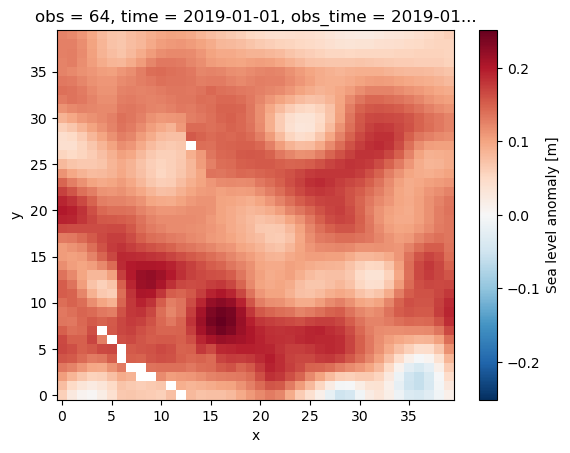

In [339]:
n_obs = 50
n_day = 0
obs = res.isel(obs=n_obs)
obs.isel(t=n_day).sla.plot()

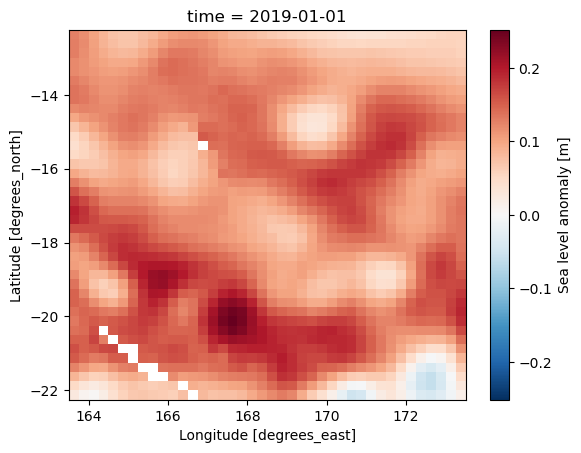

In [340]:
datacube.sel(
    time=obs.time.values[n_day].astype('datetime64[D]'),
    longitude=slice(obs.obs_lon.values-dlon, obs.obs_lon.values+dlon),
    latitude=slice(obs.obs_lat.values-dlat, obs.obs_lat.values+dlat)
).sla.plot()

In [341]:
# Calculer la taille en mémoire de chaque variable
tailles_variables = {var: res[var].nbytes for var in res.variables}

# Calculer la taille totale du dataset
taille_totale = sum(tailles_variables.values())

print("Tailles des variables individuelles :")
for var, taille in tailles_variables.items():
    print(f"{var}: {taille} bytes")

print(f"Taille totale du dataset : {taille_totale} bytes")
print(f"Taille totale du dataset : {taille_totale / (1024 ** 3)} Go")

Tailles des variables individuelles :
sla: 640000000 bytes
err_sla: 640000000 bytes
adt: 640000000 bytes
obs: 80000 bytes
latitude: 8000000 bytes
longitude: 8000000 bytes
time: 400000 bytes
obs_time: 80000 bytes
obs_lat: 80000 bytes
obs_lon: 80000 bytes
Taille totale du dataset : 1936720000 bytes
Taille totale du dataset : 1.8037110567092896 Go
